<a href="https://colab.research.google.com/github/Pappu-Meghana-Sharma/SignLanguageRecognition/blob/main/SignLanguage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ASL Alphabet dataset**
This dataset contains train and test folders.\
The structure of the data is as follows:\
asl_alphabet_train---->asl_alphabet_train---> folders for A-Z and for del nothng and space\
asl_alphabet_test data contains  a sample image for each class







# Dataset Preperation

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download grassknoted/asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zipref=zipfile.ZipFile('asl-alphabet.zip')

In [ ]:
zipref.extractall()
zipref.close()

In [ ]:
import os
for dirpath,dirnames,filenames in os.walk('asl_alphabet_train'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in \"{dirpath}\" ")

There are 1 directories and 0 images in "asl_alphabet_train" 
There are 29 directories and 0 images in "asl_alphabet_train/asl_alphabet_train" 
There are 0 directories and 3000 images in "asl_alphabet_train/asl_alphabet_train/I" 
There are 0 directories and 3000 images in "asl_alphabet_train/asl_alphabet_train/B" 
There are 0 directories and 3000 images in "asl_alphabet_train/asl_alphabet_train/P" 
There are 0 directories and 3000 images in "asl_alphabet_train/asl_alphabet_train/C" 
There are 0 directories and 3000 images in "asl_alphabet_train/asl_alphabet_train/H" 
There are 0 directories and 3000 images in "asl_alphabet_train/asl_alphabet_train/V" 
There are 0 directories and 3000 images in "asl_alphabet_train/asl_alphabet_train/F" 
There are 0 directories and 3000 images in "asl_alphabet_train/asl_alphabet_train/R" 
There are 0 directories and 3000 images in "asl_alphabet_train/asl_alphabet_train/N" 
There are 0 directories and 3000 images in "asl_alphabet_train/asl_alphabet_train/

In [ ]:
os.listdir('/content/asl_alphabet_train/asl_alphabet_train')[-5:]

['X', 'G', 'E', 'O', 'U']

In [ ]:
import shutil
import random
from tqdm import tqdm

def dataset_preparation(source_dir,dest_dir,val_split=0.1,test_split=0.1,seed=42):
  random.seed(seed)
  classes=os.listdir(source_dir)

  for cls in tqdm(classes, desc="Processing classes"): #using tqdm to visually track the progress of the classes processing
    class_path=os.path.join(source_dir,cls)
    images=os.listdir(class_path)
    random.shuffle(images)
    total_samples=len(images)
    validation_size=int(total_samples * val_split)
    test_size=int(total_samples * val_split)
    train_size=total_samples-test_size-validation_size

    splits={
        'train':images[:train_size],
        'val':images[train_size : train_size + validation_size],
        'test':images[train_size + validation_size: ]
    }

    for split,img_list in splits.items():
      split_dir=os.path.join(dest_dir,split,cls)
      os.makedirs(split_dir, exist_ok= True)

      for img in img_list:
        src=os.path.join(class_path,img)
        dst=os.path.join(split_dir,img)
        shutil.copy(src,dst)

In [ ]:
source = 'asl_alphabet_train/asl_alphabet_train'
destination = 'data'
dataset_preparation(source, destination, val_split=0.1, test_split=0.1)

Processing classes: 100%|██████████| 29/29 [00:23<00:00,  1.22it/s]


# Data Processing

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping
import matplotlib.pyplot as plt
import cv2 as cv

(<matplotlib.image.AxesImage at 0x7c78aed46fd0>, (200, 200, 3))

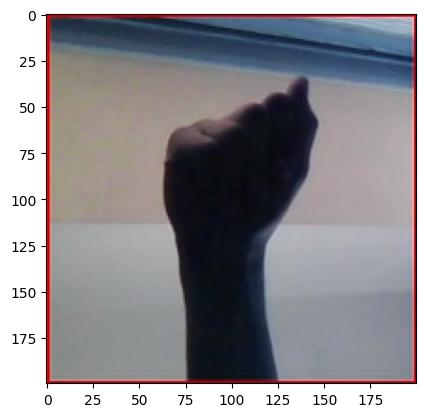

In [ ]:
img_path='data/train/A/A10.jpg'
img=cv.imread(img_path)
plt.imshow(img),img.shape

In [ ]:
classes=os.listdir('data/train')
classes.sort()
classes[:5]

['A', 'B', 'C', 'D', 'E']

In [ ]:
classes=[d for d in classes if os.path.isdir(os.path.join('data/train',d)) and not d.startswith('.')]

In [ ]:
classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

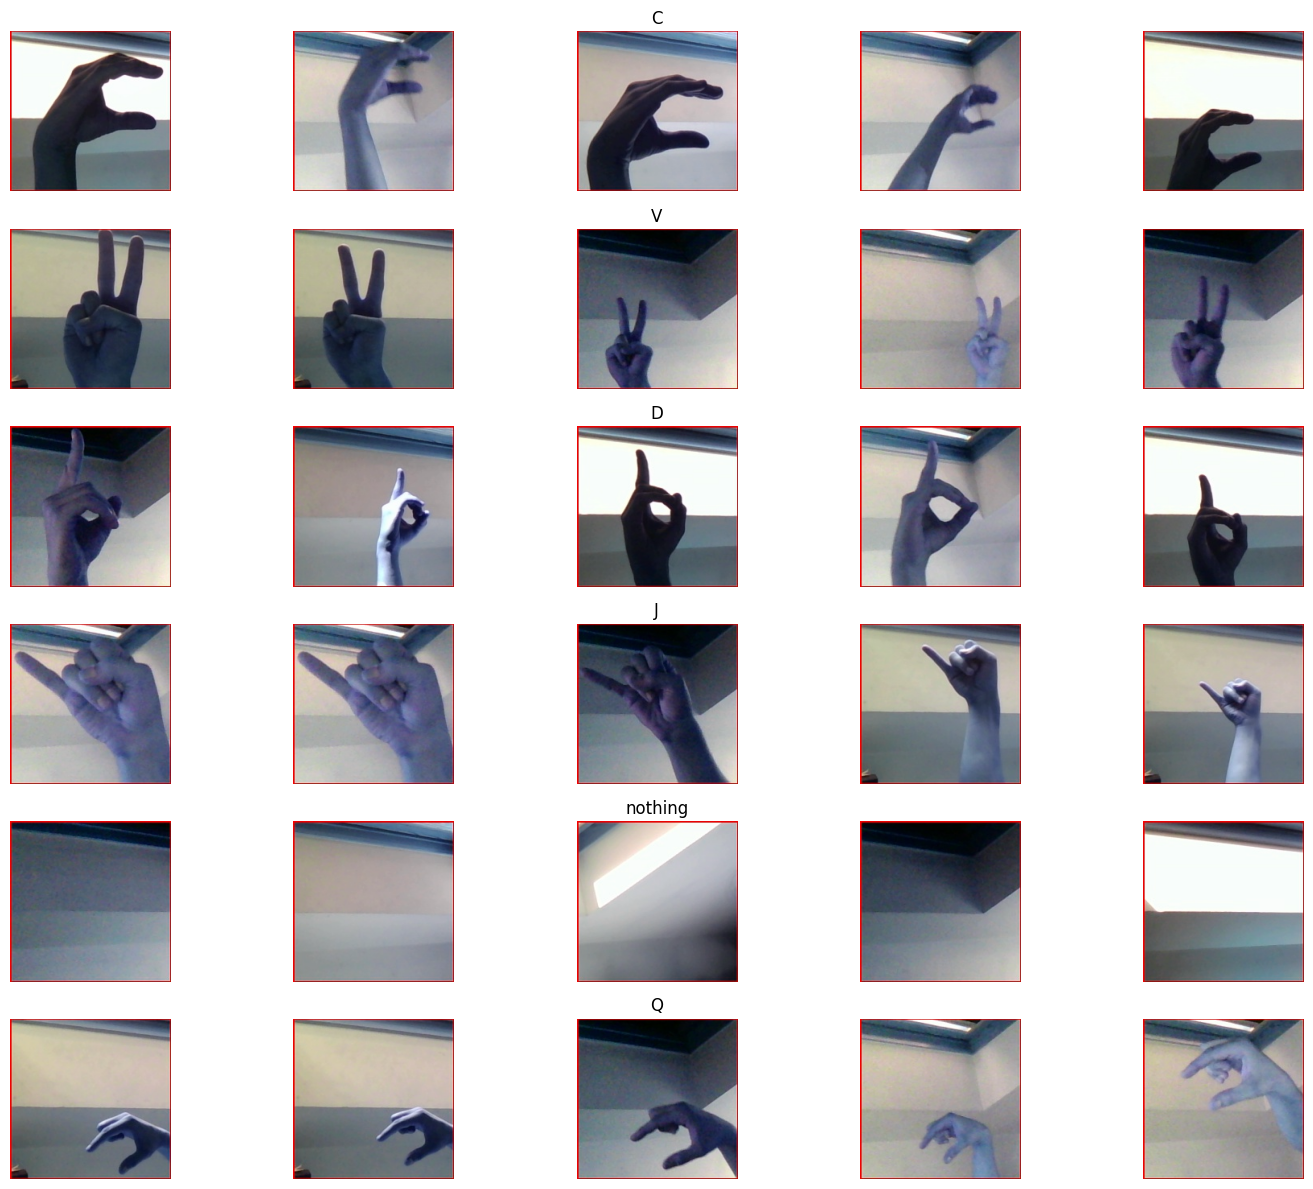

In [ ]:
num_classes=6
images_per_class=5

fig,axes=plt.subplots(num_classes,images_per_class,figsize=(15,12))

for i,cls in enumerate(random.sample(classes,num_classes)): #random.sample selects unique random elements i.e. without replacement
  class_dir=os.path.join('data/train',cls)
  images=os.listdir(class_dir)

  for j in range(images_per_class):
    img_path=os.path.join(class_dir,random.choice(images))
    img=cv.imread(img_path)

    axes[i,j].imshow(img)
    axes[i,j].axis('off')
    if j  == images_per_class // 2: #Center image
            axes[i, j].set_title(cls, fontsize=12)

plt.tight_layout()
plt.show()

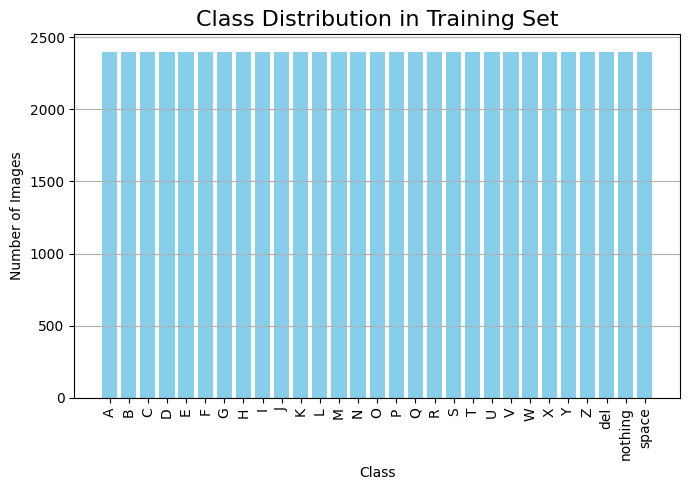

In [ ]:
class_counts={}

for cls in classes:
  class_counts[cls]=len(os.listdir(os.path.join('data/train',cls)))

plt.figure(figsize=(7,5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Set", fontsize=16)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
BATCH_SIZE=64
IMAGE_SHAPE=(224,224)
train_dir='data/train'
val_dir='data/val'
test_dir='data/test'
train_data=tf.keras.utils.image_dataset_from_directory(train_dir,
                                                 image_size=IMAGE_SHAPE,
                                                 batch_size=BATCH_SIZE,
                                                 label_mode='categorical',
                                                 shuffle=True).prefetch(tf.data.AUTOTUNE)
val_data=tf.keras.utils.image_dataset_from_directory(val_dir,
                                                 image_size=IMAGE_SHAPE,
                                                 batch_size=BATCH_SIZE,
                                                 label_mode='categorical',
                                                 shuffle=False).prefetch(tf.data.AUTOTUNE)
test_data=tf.keras.utils.image_dataset_from_directory(test_dir,
                                                 image_size=IMAGE_SHAPE,
                                                 batch_size=BATCH_SIZE,
                                                 label_mode='categorical',
                                                 shuffle=False).prefetch(tf.data.AUTOTUNE)

Found 69600 files belonging to 29 classes.
Found 8700 files belonging to 29 classes.
Found 8700 files belonging to 29 classes.


# Custom Model Building and Evaluation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224,224,3)),
    tf.keras.layers.Conv2D(64,kernel_size=5,activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(16,kernel_size=3,activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(29,activation='softmax')

])

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
early_stopping=EarlyStopping(monitor='val_loss',restore_best_weights=True)
history=model.fit(train_data,epochs=20,validation_data=val_data,callbacks=[early_stopping])

Epoch 1/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 250s 211ms/step - accuracy: 0.2746 - loss: 3.1493 - val_accuracy: 0.7940 - val_loss: 0.8053
Epoch 2/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 216s 186ms/step - accuracy: 0.7603 - loss: 0.8631 - val_accuracy: 0.9151 - val_loss: 0.3978
Epoch 3/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 261s 185ms/step - accuracy: 0.8613 - loss: 0.5278 - val_accuracy: 0.9570 - val_loss: 0.2345
Epoch 4/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 152s 139ms/step - accuracy: 0.9051 - loss: 0.3724 - val_accuracy: 0.9632 - val_loss: 0.1909
Epoch 5/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 263s 195ms/step - accuracy: 0.9281 - loss: 0.2868 - val_accuracy: 0.9757 - val_loss: 0.1396
Epoch 6/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 156s 98ms/step - accuracy: 0.9411 - loss: 0.2371 - val_accuracy: 0.9805 - val_loss: 0.1115
Epoch 7/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 145s 101ms/step - accuracy: 0.9510 - loss: 0.1996 - val_accuracy: 0.9751 - val_loss: 0.1277


In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.9839 - loss: 0.1043
Test Accuracy: 0.9813, Test Loss: 0.1122


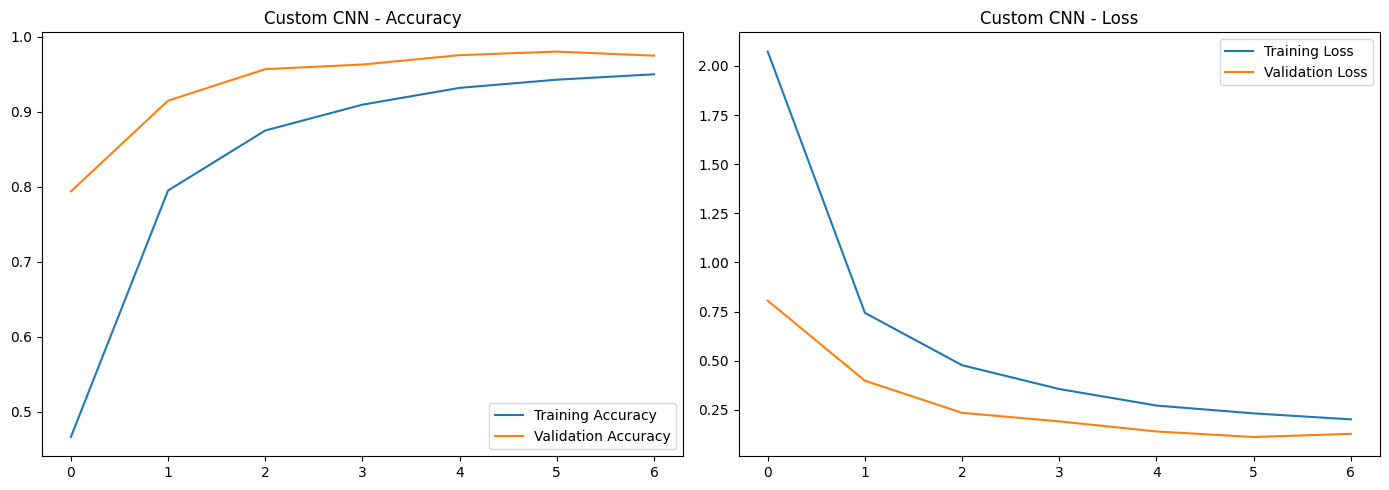

In [ ]:
def plot_history(history, title='Model Performance'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history, title='Custom CNN')


In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title, fontsize=16)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_data], axis=0)
def get_predictions(model, data):
    y_pred = model.predict(data)
    return np.argmax(y_pred, axis=1)

136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step


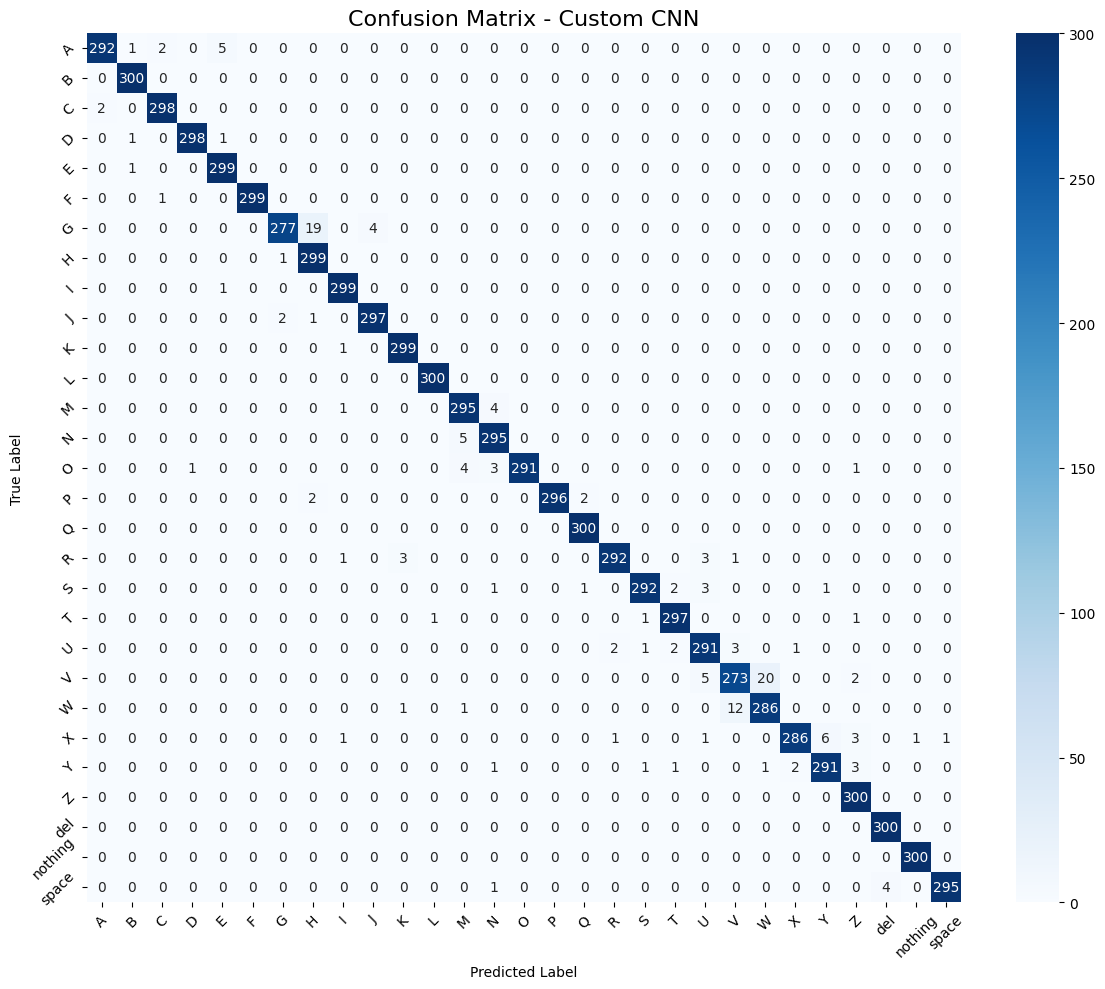

In [ ]:
y_pred_custom = get_predictions(model, test_data)
plot_confusion_matrix(y_true, y_pred_custom, class_names=classes, title="Confusion Matrix - Custom CNN")

In [ ]:
# Save complete model
model.save('custom_cnn_model.h5')


#Feature Extracation

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 102s 83ms/step - accuracy: 0.7263 - loss: 0.9827 - val_accuracy: 0.9872 - val_loss: 0.0650
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 115s 64ms/step - accuracy: 0.9642 - loss: 0.1215 - val_accuracy: 0.9899 - val_loss: 0.0349
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.9784 - loss: 0.0736 - val_accuracy: 0.9944 - val_loss: 0.0218
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 73s 67ms/step - accuracy: 0.9818 - loss: 0.0572 - val_accuracy: 0.9956 - val_loss: 0.0169
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.9828 - loss: 0.0518 - val_accuracy: 0.9962 - val_loss: 0.0136
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 73s 67ms/step - accuracy: 0.9869 - loss: 0.0398 - val_accuracy: 0.9962 - val_loss: 0.0124
Epoch 7/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 73s 67ms/step - accuracy: 0.9878 - loss: 0.0374 - val_accuracy: 0.9952 - val_loss: 0.0152


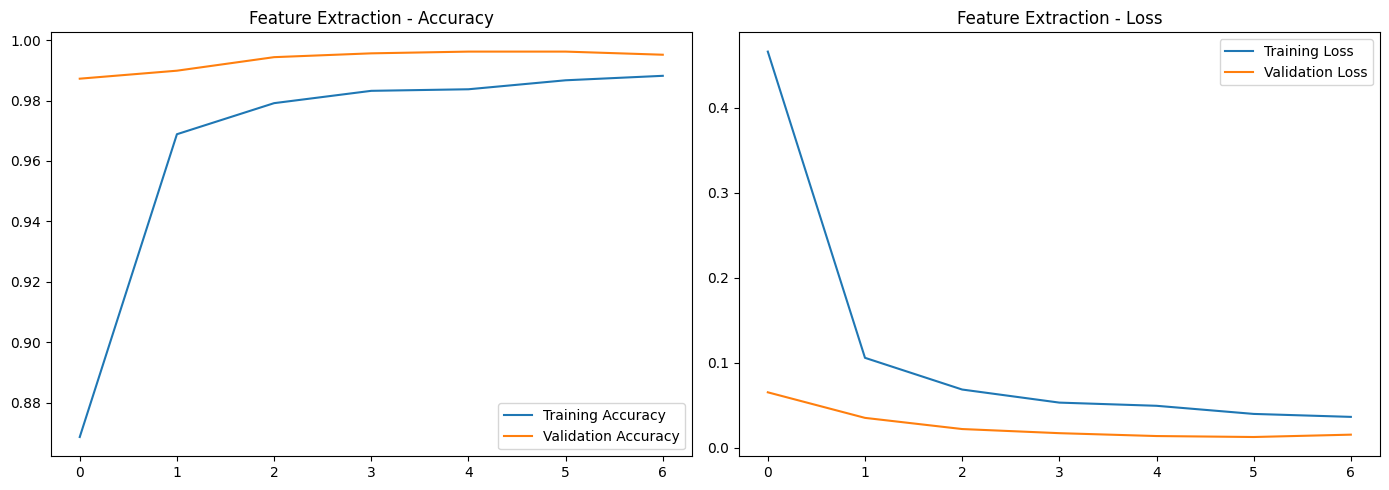

In [ ]:
inputs = tf.keras.Input(shape=(224,224,3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

feature_extraction_model = tf.keras.Model(inputs, outputs)

feature_extraction_model.compile(optimizer=tf.keras.optimizers.Adam(),
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])

history_fe = feature_extraction_model.fit(train_data,
                                          epochs=10,
                                          validation_data=val_data,
                                          callbacks=[early_stopping])

plot_history(history_fe, title='Feature Extraction')

In [ ]:
test_loss, test_acc = feature_extraction_model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9975 - loss: 0.0087
Test Accuracy: 0.9969, Test Loss: 0.0101


136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step


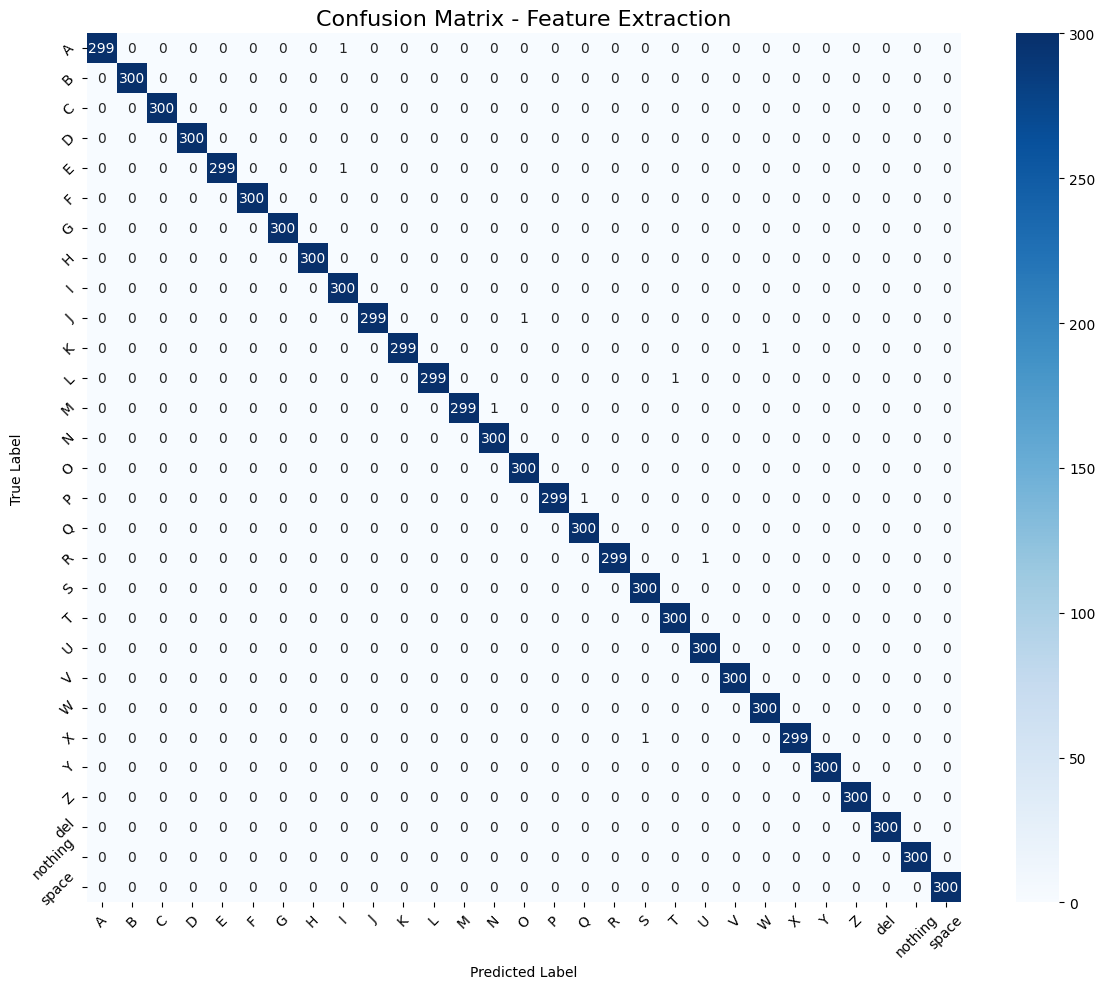

In [ ]:
y_pred_fe = get_predictions(feature_extraction_model, test_data)
plot_confusion_matrix(y_true, y_pred_fe, class_names=classes, title="Confusion Matrix - Feature Extraction")

In [ ]:
from google.colab import files
feature_extraction_model.save('feature_extraction_model.h5')
files.download('feature_extraction_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Fine Tuning

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-15]:  # Freeze all but last 15 layers
    layer.trainable = False

fine_tune_model = tf.keras.Model(inputs, outputs)

fine_tune_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

history_ft = fine_tune_model.fit(train_data,
                                 epochs=10,
                                 validation_data=val_data,
                                 callbacks=[early_stopping])

Epoch 1/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 101s 81ms/step - accuracy: 0.9054 - loss: 0.3471 - val_accuracy: 0.9944 - val_loss: 0.0170
Epoch 2/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 125s 71ms/step - accuracy: 0.9829 - loss: 0.0520 - val_accuracy: 0.9962 - val_loss: 0.0099
Epoch 3/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 79s 68ms/step - accuracy: 0.9908 - loss: 0.0281 - val_accuracy: 0.9977 - val_loss: 0.0067
Epoch 4/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.9947 - loss: 0.0176 - val_accuracy: 0.9983 - val_loss: 0.0051
Epoch 5/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.9962 - loss: 0.0136 - val_accuracy: 0.9984 - val_loss: 0.0040
Epoch 6/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 73s 67ms/step - accuracy: 0.9969 - loss: 0.0107 - val_accuracy: 0.9993 - val_loss: 0.0027
Epoch 7/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 80s 73ms/step - accuracy: 0.9981 - loss: 0.0072 - val_accuracy: 0.9990 - val_loss: 0.0023
Epoch 8/10
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 93s 86ms/step - accuracy: 0.9981

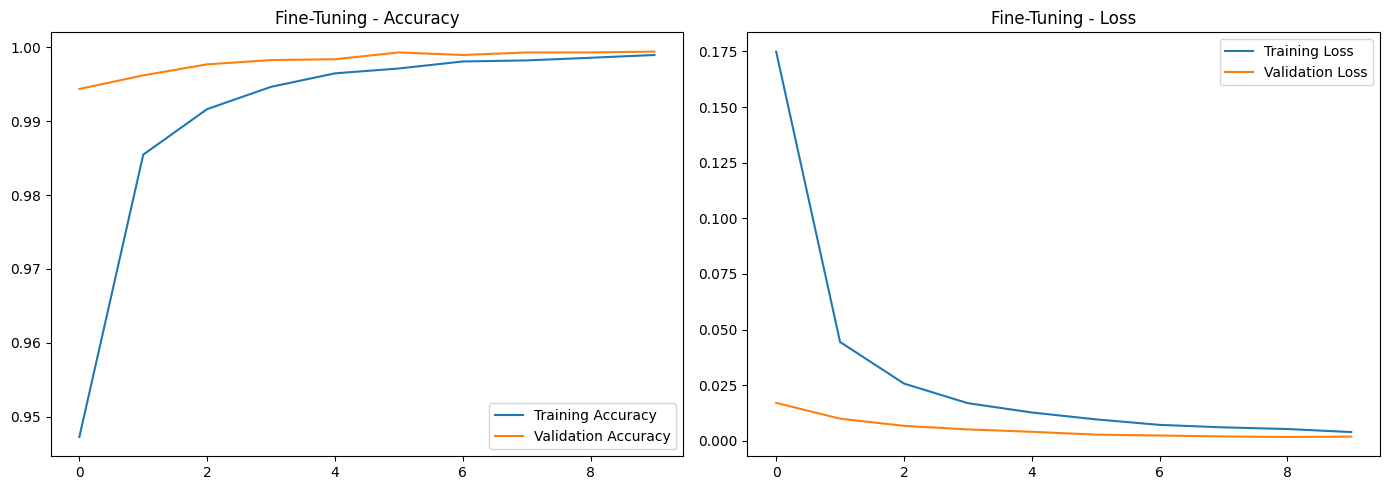

In [ ]:
plot_history(history_ft, title='Fine-Tuning')

In [ ]:
test_loss, test_acc = fine_tune_model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9987 - loss: 0.0024
Test Accuracy: 0.9990, Test Loss: 0.0025


136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step


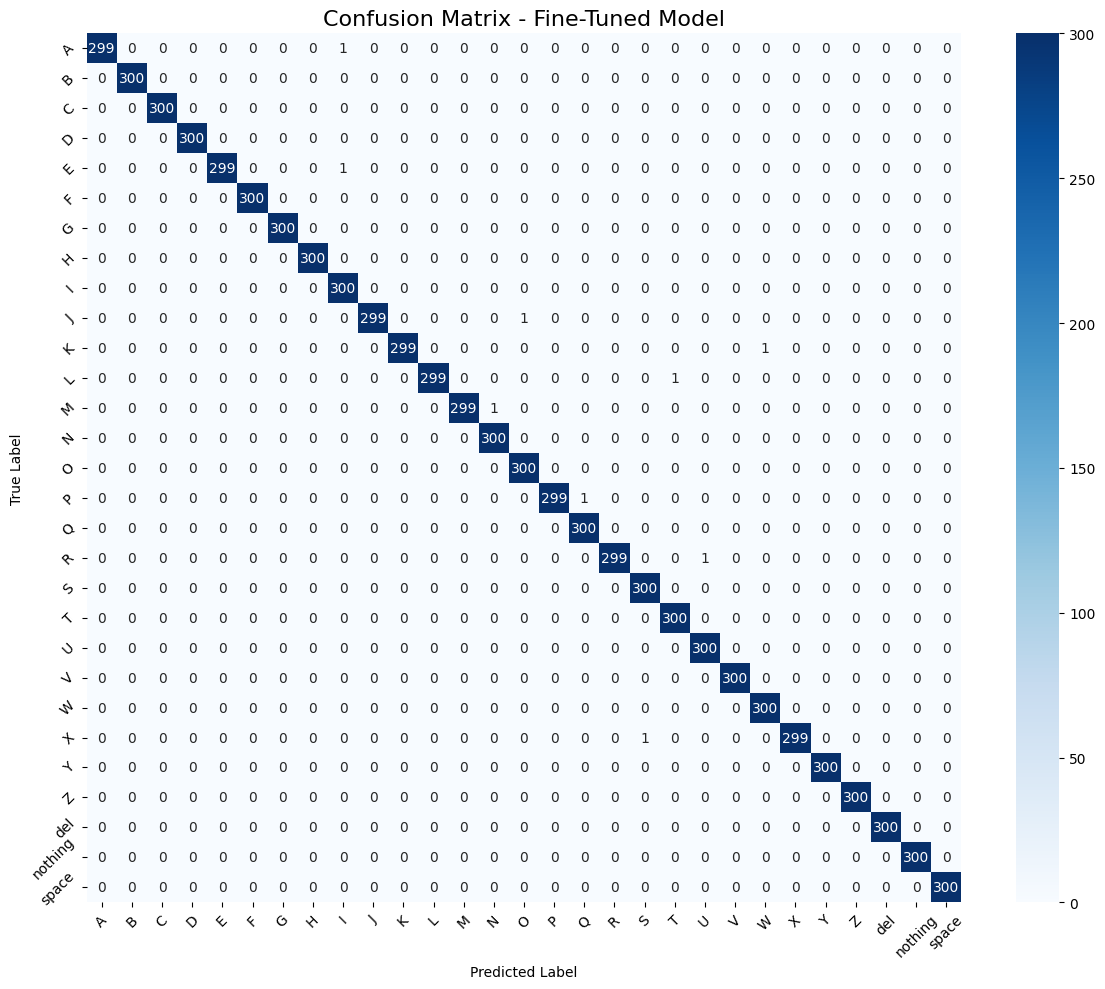

In [ ]:
y_pred_ft = get_predictions(fine_tune_model, test_data)
plot_confusion_matrix(y_true, y_pred_ft, class_names=classes, title="Confusion Matrix - Fine-Tuned Model")

In [ ]:
fine_tune_model.save('fine_tuning_model.h5')
files.download('fine_tuning_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Comparisions


In [ ]:
def evaluate_from_preds(model_name, y_true, y_pred, class_names):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"\n {model_name}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")

    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }


In [ ]:
results = []

results.append(evaluate_from_preds("Custom CNN", y_true, y_pred_custom, classes))
results.append(evaluate_from_preds("Feature Extraction", y_true, y_pred_fe, classes))
results.append(evaluate_from_preds("Fine-Tuned Model", y_true, y_pred_ft, classes))



 Custom CNN
Accuracy:  0.9813
Precision: 0.9815
Recall:    0.9813
F1-score:  0.9812

 Feature Extraction
Accuracy:  0.9990
Precision: 0.9990
Recall:    0.9990
F1-score:  0.9990

 Fine-Tuned Model
Accuracy:  0.9990
Precision: 0.9990
Recall:    0.9990
F1-score:  0.9990
